In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import io
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [26]:
# Import Data
print("\n---- Dataset Info ----")
gesture_data = pd.read_csv("imu_data.csv")

# Separate inputs and outputs
x = gesture_data.iloc[:, :-1].values  # Input (first 300 columns)
y = gesture_data.iloc[:, -1].values   # Output (column 301)

# Convert string labels to numeric (0-3)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Save the encoder for future use (important for inference)
joblib.dump(label_encoder, "label_encoder.pkl")

# Print dataset info
print(f"gesture_data.shape = {gesture_data.shape}")
print(f"features.shape = {x.shape}")
print(f"labels.shape = {y.shape}")
print("Label Mapping:", label_mapping)
print("\n")


---- Dataset Info ----
gesture_data.shape = (50, 301)
features.shape = (50, 300)
labels.shape = (50,)
Label Mapping: {'bathroom': 0, 'food': 1, 'hello': 2, 'please': 3, 'yes': 4}




In [27]:
# Settings
inputShape = (300,) # Change this to match the size of input
nsamples = 50       # Number of samples to use as a dataset
val_ratio = 0.1     # % of samples that should be held for validation set
test_ratio = 0.1    # % of samples that should be held for test set
tflite_model_name = 'SIGNSPEAK_MLP_full_model'    # Will be given .tflite suffix
c_model_name = 'SIGNSPEAK_MLP_full_model'         # Will be given .h suffix

Training: (40, 300), Validation: (5, 300), Testing: (5, 300)


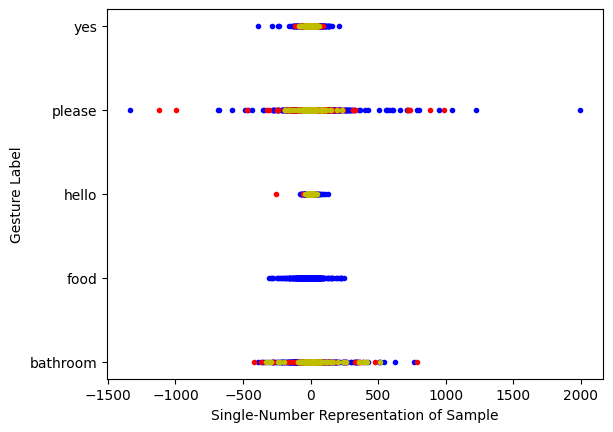

In [28]:
# Split the dataset into training, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Testing: {x_test.shape}")

# Check that our splits add up to nsamples
assert(x_train.shape[0] + x_val.shape[0] + x_test.shape[0]) == nsamples

# Get unique numerical labels and corresponding string labels
unique_labels = np.unique(y)
string_labels = label_encoder.inverse_transform(unique_labels)

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")


plt.yticks(unique_labels, string_labels) # Set y-axis ticks and labels

plt.xlabel("Single-Number Representation of Sample") #
plt.ylabel("Gesture Label")
plt.show()

In [29]:
# Create a model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(300,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')  # Ensure 5 gesture classes
])

model.summary() # Print model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,989 (39.02 KB)

 Trainable params: 9,989 (39.02 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Train model
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=16,  # Small batch size for generalization
                    validation_data=(x_val, y_val))


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 120, but received input with shape (None, 300)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 300), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Plot predictions against actual values
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(y_test, y_test, 'b.', label='Actual') # Plot actual vs actual for diagonal line
plt.scatter(y_test, predicted_labels, c='r', marker='x', label='Prediction') # Scatter predicted vs actual
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += 'unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif // ' + var_name.upper() + '_H'

    return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))